In [1]:
%matplotlib inline
import pandas as pd
import nupis
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gp
import pysal as ps
import pysal.contrib.viz.mapping as maps
import palettable

pd.options.mode.chained_assignment = None

sns.set(style='whitegrid', palette='bright', context='notebook')

### Setores censitários

Para baixar as malhas dos outros estados do Brasil ir em:

ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_de_setores_censitarios__divisoes_intramunicipais/censo_2010/setores_censitarios_shp/

Para baixar o arquivo com as variáveis por setores censitários em MG:

ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/

Dicas em: http://www.analisededadosempython.org/espacial

In [2]:
# estado de Minas Gerais dividido em setores censitários
setores = gp.read_file('dados/31SEE250GC_SIR.shp') 
setores.shape

(32807, 14)

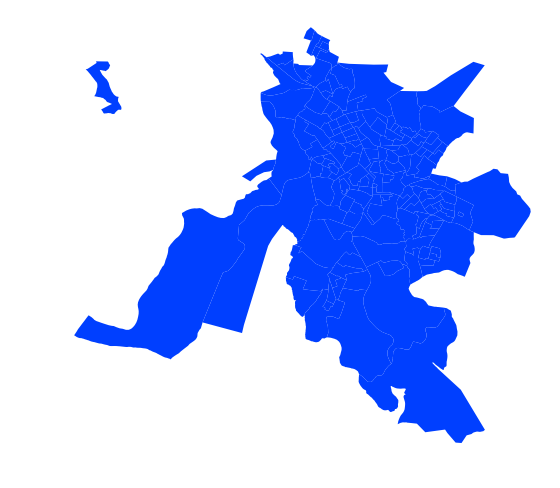

In [3]:
# a partir do shapefile de setores de MG, selecionar o município de Varginha e apenas os setores urbanos
vga = setores.query('NM_MUNICIP == "VARGINHA"')
mapa_vga = vga.query('TIPO == "URBANO"')
mapa_vga.plot(figsize=(9,9)).set_axis_off();

### Agora vamos pegar variáveis sobre os setores censitários de MG e utilizar os de Varginha.

Escolher alguma planilha de dados com informações sobre setores censitários. Havíamos utilizado 'basico_MG.csv', agora podemos escolher outra mais completa dentre as disponíveis:

- No endereço 
ftp://ftp.ibge.gov.br/Censos/Censo_Demografico_2010/Resultados_do_Universo/Agregados_por_Setores_Censitarios/
há várias planilhas no arquivo .zip de Minas Gerais (o arquivo mais recente é MG_20171016.zip)  
- Na documentação (arquivo 1_Documentacao_Agregado_dos_Setores_2010_20171016.zip) há um pdf com as explicações sobre todas as planilhas e variáveis existentes (no meu site o arquivo se chama 'base_setores_censitarios_censo_2010.pdf')  

Escolha uma planilha (sobre domicílio, entorno, pessoa etc.) baseando-se nas explicações do pdf. Carregue tal planilha e faça a análise espacial da(s) variável(is) escolhida(s) para Varginha.

Realizar todos os ajustes necessários.

Eu escolhi a planilha 'Domicilio01_MG.csv'. Há duas planilhas (Domicilio01_UF e Domicilio02_UF) que fornecem informações sobre características dos domicílios, informações sobre os moradores por sexo, idade e características do domicílio.

In [4]:
# carregar arquivo maior com dados sobre os setores censitários de MG
mg = pd.read_csv('dados/Domicilio01_MG.csv', encoding='latin1', sep=';', decimal=',')
mg.shape

(32564, 244)

In [5]:
# verificar quais as variáveis disponíveis
mg.columns

Index(['Cod_setor', 'Situacao_setor', 'V001', 'V002', 'V003', 'V004', 'V005',
       'V006', 'V007', 'V008',
       ...
       'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241',
       'Unnamed: 243'],
      dtype='object', length=244)

In [6]:
# variável de identificação do setor censitário
mg.Cod_setor

0        310010405000001
1        310010405000002
2        310010405000003
3        310010405000004
4        310010405000005
5        310010405000006
6        310010405000007
7        310010405000008
8        310010405000009
9        310010405000010
10       310010405000011
11       310010405000012
12       310010405000013
13       310020305000001
14       310020305000002
15       310020305000003
16       310020305000004
17       310020305000005
18       310020305000006
19       310020305000007
20       310020305000008
21       310020305000009
22       310020305000010
23       310020305000011
24       310020305000012
25       310020305000013
26       310020305000014
27       310020305000015
28       310020305000016
29       310020305000017
              ...       
32534    317200405000048
32535    317200405000049
32536    317200405000050
32537    317200405000051
32538    317200405000052
32539    317200405000053
32540    317200405000054
32541    317200405000055
32542    317200405000056


Como vamos unir o *dataframe* de informações geográficas com o *dataframe* das variáveis, a coluna de identificação deve possuir os mesmos códigos.

In [7]:
mapa_vga.columns

Index(['ID', 'CD_GEOCODI', 'TIPO', 'CD_GEOCODB', 'NM_BAIRRO', 'CD_GEOCODS',
       'NM_SUBDIST', 'CD_GEOCODD', 'NM_DISTRIT', 'CD_GEOCODM', 'NM_MUNICIP',
       'NM_MICRO', 'NM_MESO', 'geometry'],
      dtype='object')

In [8]:
mapa_vga.CD_GEOCODI

28746    317070105000061
28747    317070105000062
28748    317070105000063
28749    317070105000064
28750    317070105000065
28751    317070105000066
28752    317070105000067
28753    317070105000068
28754    317070105000069
28755    317070105000070
28756    317070105000071
28757    317070105000072
28758    317070105000073
32028    317070105000004
32029    317070105000005
32030    317070105000006
32031    317070105000007
32032    317070105000008
32033    317070105000009
32034    317070105000010
32035    317070105000011
32036    317070105000012
32037    317070105000013
32038    317070105000104
32039    317070105000105
32040    317070105000106
32041    317070105000107
32042    317070105000108
32043    317070105000109
32044    317070105000110
              ...       
32248    317070105000132
32249    317070105000133
32250    317070105000134
32251    317070105000135
32252    317070105000136
32264    317070105000148
32265    317070105000149
32266    317070105000150
32267    317070105000151


In [9]:
# transformar a variável CD_GEOCODI, que contém o código do setor, em inteiro
# e criar nova coluna chamada 'Cod_setor' para coincidir com o dataframe mg
mapa_vga.CD_GEOCODI = mapa_vga.CD_GEOCODI.astype('int64')
mapa_vga['Cod_setor'] = mapa_vga.CD_GEOCODI

In [10]:
# colocar esses códigos em uma lista para ser possível utilizar o query
codigos = mapa_vga.Cod_setor.astype('int64').values.tolist()

In [11]:
# verificar se os códigos estão batendo entre os dois dataframes (malha e Domicilio01)
mg.query('Cod_setor == @codigos')

,Cod_setor,Situacao_setor,V001,V002,V003,V004,V005,V006,V007,V008,...,V233,V234,V235,V236,V237,V238,V239,V240,V241,Unnamed: 243
31834,317070105000001,1,260,260,189,5,66,157,0,93,...,0,0,0,0,0,0,0,0,0,NaN
31835,317070105000002,1,292,286,137,1,148,135,4,133,...,0,0,0,0,0,0,0,0,0,NaN
31836,317070105000003,1,232,232,197,5,27,122,0,91,...,0,0,0,0,0,0,0,0,0,NaN
31837,317070105000004,1,283,279,89,0,190,160,8,99,...,0,0,0,0,0,0,0,0,0,NaN
31838,317070105000005,1,289,289,43,3,243,159,3,113,...,0,0,0,0,0,0,0,0,0,NaN
31839,317070105000006,1,241,241,131,0,110,142,2,84,...,0,1,1,0,0,0,0,0,0,NaN
31840,317070105000007,1,247,246,155,0,91,111,5,110,...,0,0,0,0,0,0,0,0,0,NaN
31841,317070105000008,1,268,268,263,0,5,141,5,91,...,0,4,1,3,0,0,0,0,0,NaN
31842,317070105000009,1,248,248,243,0,5,138,7,61,...,0,0,0,0,0,0,0,0,0,NaN
31843,317070105000010,1,200,200,199,0,1,110,3,65,...,0,0,0,0,0,0,0,0,0,NaN


In [12]:
varginha = pd.merge(mapa_vga, mg, on='Cod_setor')
varginha

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,...,V233,V234,V235,V236,V237,V238,V239,V240,V241,Unnamed: 243
0,32172,317070105000061,URBANO,317070105013,Campos Elíseos,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
1,32173,317070105000062,URBANO,317070105013,Campos Elíseos,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
2,32174,317070105000063,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
3,32175,317070105000064,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
4,32176,317070105000065,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
5,32177,317070105000066,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
6,32178,317070105000067,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
7,32179,317070105000068,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN
8,32180,317070105000069,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,1,1,0,0,0,0,0,0,NaN
9,32181,317070105000070,URBANO,317070105014,Barcelona,31707010500,None,317070105,VARGINHA,3170701,...,0,0,0,0,0,0,0,0,0,NaN


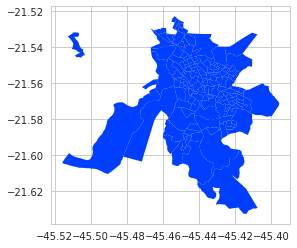

In [13]:
varginha.plot();

### Tarefa: escolher uma das variáveis (V001, $\dots$) e realizar a AEDE (análise exploratória de dados espaciais)

- plotar mapa temático com intervalos iguais  
- plotar mapa temático com intervalos baseados em quantis (melhorar a posição da legenda se necessário)  
- obter boxplot da variável  
- obter $I$ de Moran para a variável e avaliar significância  
- obter diagrama de dispersão de Moran para a variável (com nomes nos eixos)  
- obter mapa LISA
- plotar os bairros correspondentes a *clusters* ou *outliers*

V178: Domicílios particulares permanentes do tipo apartamento próprios e quitados

V180: Domicílios particulares permanentes do tipo apartamento alugados

In [17]:
# aqui substituir por outra variável
v = 'V178'

In [18]:
varginha[v] = varginha[v].astype('float64')

In [19]:
# resumo estatístico
varginha[v].describe()

count    161.000000
mean       5.403727
std       16.201998
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max      131.000000
Name: V178, dtype: float64

In [20]:
# obter a matriz w de pesos espaciais
# lembrar de salvar um shapefile (.shp) apenas com as informações dos setores de Varginha (objeto mapa_vga)
# como fizemos na aula p4
mapa_vga.to_file('vga_setores.shp')    # salvar o shapefile dos setores
w = ps.queen_from_shapefile('vga_setores.shp') # calcular a matriz de vizinhança

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))


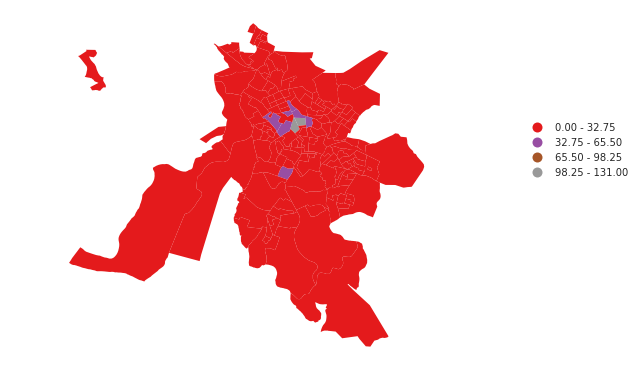

In [21]:
# mapa temático
ax = varginha.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

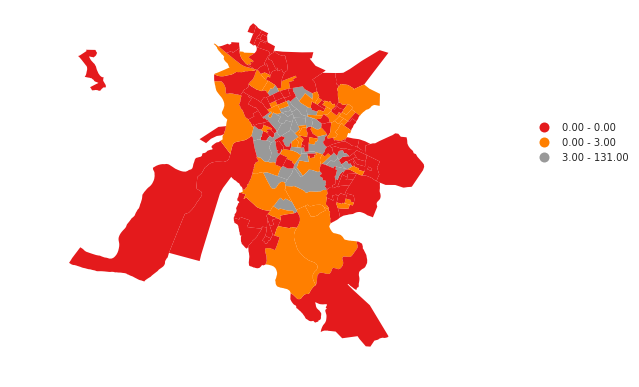

In [22]:
# mapa temático - problema devido aos valores faltantes da variável V007
ax = varginha.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

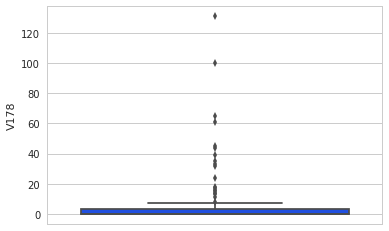

In [23]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=varginha, orient='v');

In [24]:
IM = ps.Moran(varginha[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

('WARNING: ', 135, ' is an island (no neighbors)')
Moran Rate Summary Report
I        0.458   observed value of Moran’s I
EI_sim   -0.005   average value of I from permutations  
p_sim     0.001   p-value based on permutations


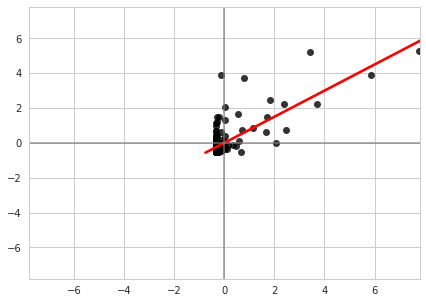

In [25]:
nupis.moran_dispersao(IM)   # diagrama de dispersão de Moran que recebe o objeto criado antes

### Mapas LISA

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

('WARNING: ', 135, ' is an island (no neighbors)')


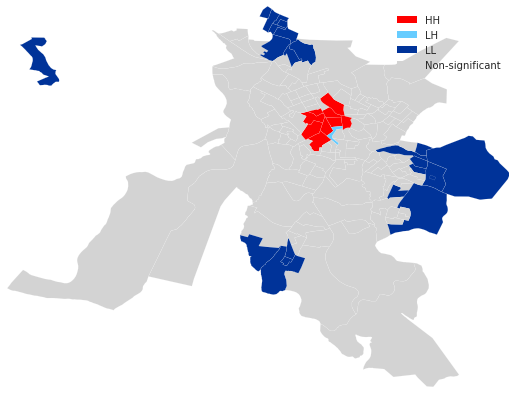

In [26]:
nupis.lisa_mapa(varginha[v], 'vga_setores.shp', p_thres=0.05)   # função do nupis para obter o mapa LISA

In [27]:
shapefile = 'vga_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(varginha[v], w)
p_thres = 0.05

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

In [28]:
import numpy as np
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
varginha['quad'] = lisa.q
mun_sig = varginha.loc[posicoes[0], ['NM_BAIRRO', 'quad']]
# ou ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')
setores_escolhidos = varginha.iloc[mun_sig.index, :]

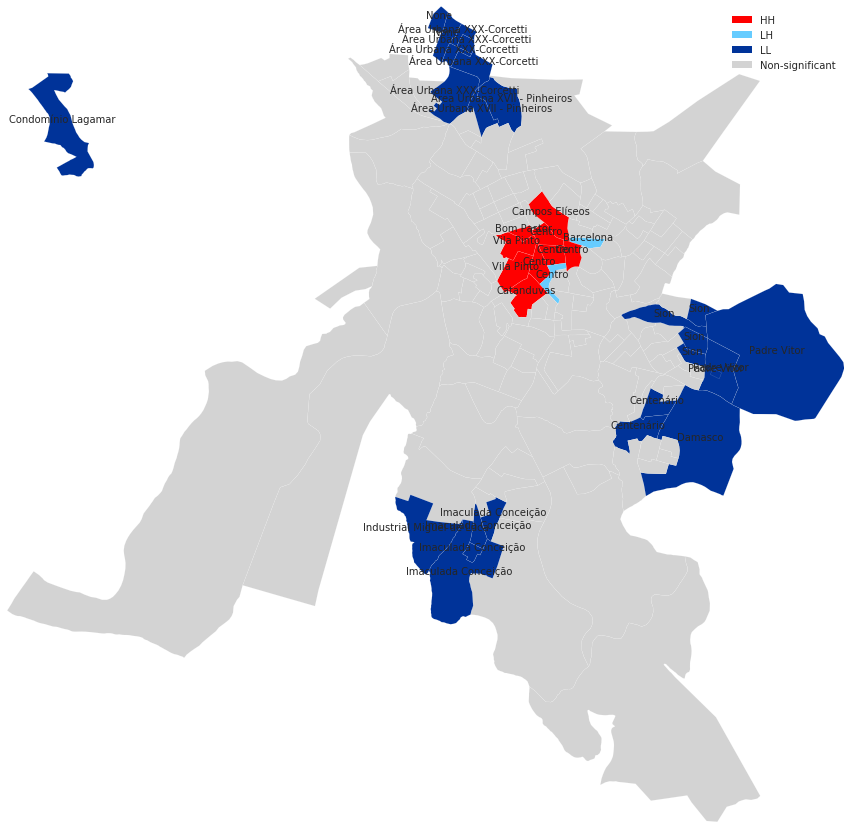

In [29]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(15, 15))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in setores_escolhidos.index:

    plt.text(setores_escolhidos.geometry.centroid[i].coords[0][0], setores_escolhidos.geometry.centroid[i].coords[0][1], 
             setores_escolhidos.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')

Agora a análise será somando as variáveis V178 e V180 e, com isso, teremos o total de apartamentos quitados e alugados.

In [32]:
varginha['V178'] = varginha['V178'].astype('float64')
varginha['V180'] = varginha['V180'].astype('float64')

In [33]:
varginha['aptos'] = varginha['V178'] + varginha['V180']

In [34]:
varginha['V178'].describe()

count    161.000000
mean       5.403727
std       16.201998
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max      131.000000
Name: V178, dtype: float64

In [35]:
varginha['V180'].describe()

count    161.000000
mean       6.391304
std       14.256654
min        0.000000
25%        0.000000
50%        1.000000
75%        5.000000
max       99.000000
Name: V180, dtype: float64

In [37]:
varginha['aptos'].describe()

count    161.000000
mean      11.795031
std       29.801661
min        0.000000
25%        0.000000
50%        2.000000
75%        9.000000
max      230.000000
Name: aptos, dtype: float64

In [38]:
v = 'aptos'

In [39]:
# resumo estatístico da nova variável
varginha[v].describe()

count    161.000000
mean      11.795031
std       29.801661
min        0.000000
25%        0.000000
50%        2.000000
75%        9.000000
max      230.000000
Name: aptos, dtype: float64

In [40]:
# obter a matriz w de pesos espaciais
# lembrar de salvar um shapefile (.shp) apenas com as informações dos setores de Varginha (objeto mapa_vga)
# como fizemos na aula p4
mapa_vga.to_file('vga_setores.shp')    # salvar o shapefile dos setores
w = ps.queen_from_shapefile('vga_setores.shp') # calcular a matriz de vizinhança

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))


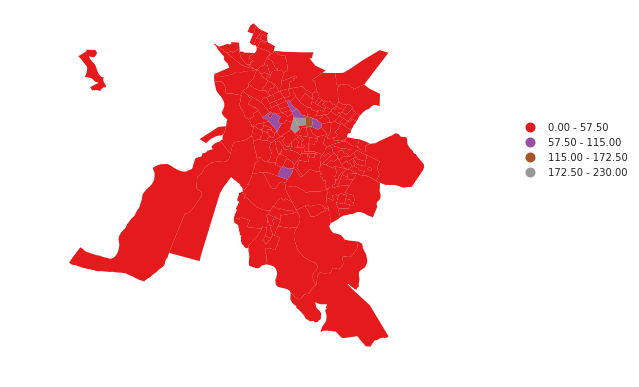

In [41]:
# mapa temático
ax = varginha.plot(column=v, scheme='equal_interval', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

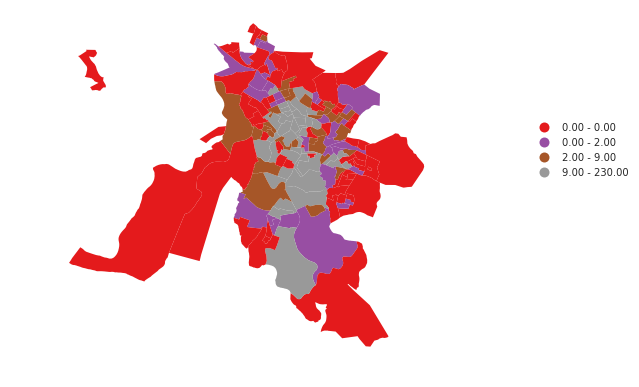

In [42]:
# mapa temático - problema devido aos valores faltantes da variável V007
ax = varginha.plot(column=v, scheme='quantiles', k=4, linewidth=0, 
                   figsize=(7,7), legend=True, cmap='Set1')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.5, 0.7)); # alterar valores de x e y: posição
ax.set_axis_off();

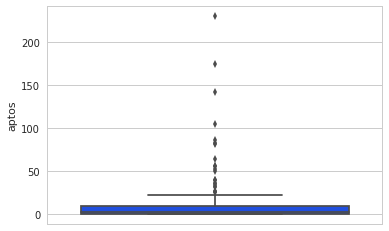

In [43]:
# usar algum gráfico descritivo que represente os mesmos valores e dê ideia da dispersão
sns.boxplot(v, data=varginha, orient='v');

In [44]:
IM = ps.Moran(varginha[v], w)  # variável no dataframe e matriz de vizinhança 
nupis.moran_resumo(IM)         # função do nupis que retorna uma saída organizada do I de Moran

('WARNING: ', 135, ' is an island (no neighbors)')
Moran Rate Summary Report
I        0.469   observed value of Moran’s I
EI_sim   -0.005   average value of I from permutations  
p_sim     0.001   p-value based on permutations


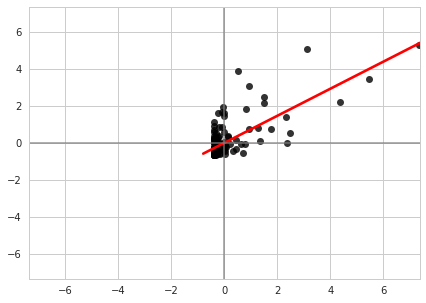

In [45]:
nupis.moran_dispersao(IM)   # diagrama de dispersão de Moran que recebe o objeto criado antes

### Mapas LISA

/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

('WARNING: ', 135, ' is an island (no neighbors)')


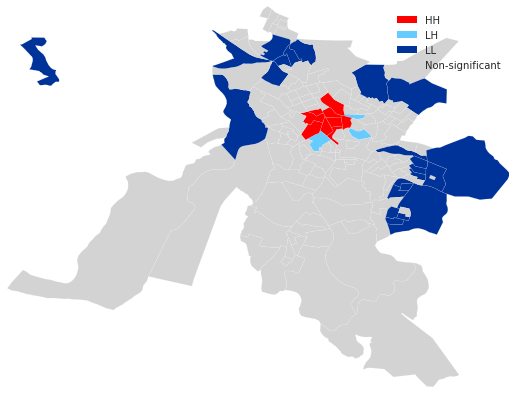

In [46]:
nupis.lisa_mapa(varginha[v], 'vga_setores.shp', p_thres=0.05)   # função do nupis para obter o mapa LISA

In [47]:
shapefile = 'vga_setores.shp'
w = ps.queen_from_shapefile(shapefile)
lisa = ps.Moran_Local(varginha[v], w)
p_thres = 0.05

('WARNING: ', 135, ' is an island (no neighbors)')


/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:186: UserWarning: There is one disconnected observation (no neighbors)
  warnings.warn("There is one disconnected observation (no neighbors)")
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/weights/weights.py:187: UserWarning: Island id: 135
  warnings.warn("Island id: %s" % str(self.islands[0]))
/home/patricia/anaconda3/lib/python3.6/site-packages/pysal/esda/moran.py:851: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/patricia/anaconda3/lib/python3.6/site-packages/sci

In [48]:
import numpy as np
lisa.p_sim  # pseudovalores do LISA
sig = lisa.p_sim < 0.05  # identificar significativos
lisa.p_sim[sig]
posicoes = np.where(sig)
varginha['quad'] = lisa.q
mun_sig = varginha.loc[posicoes[0], ['NM_BAIRRO', 'quad']]
# ou ssm.loc[posicoes[0], ['nome_mun', 'quad']].query('quad == 4')
setores_escolhidos = varginha.iloc[mun_sig.index, :]

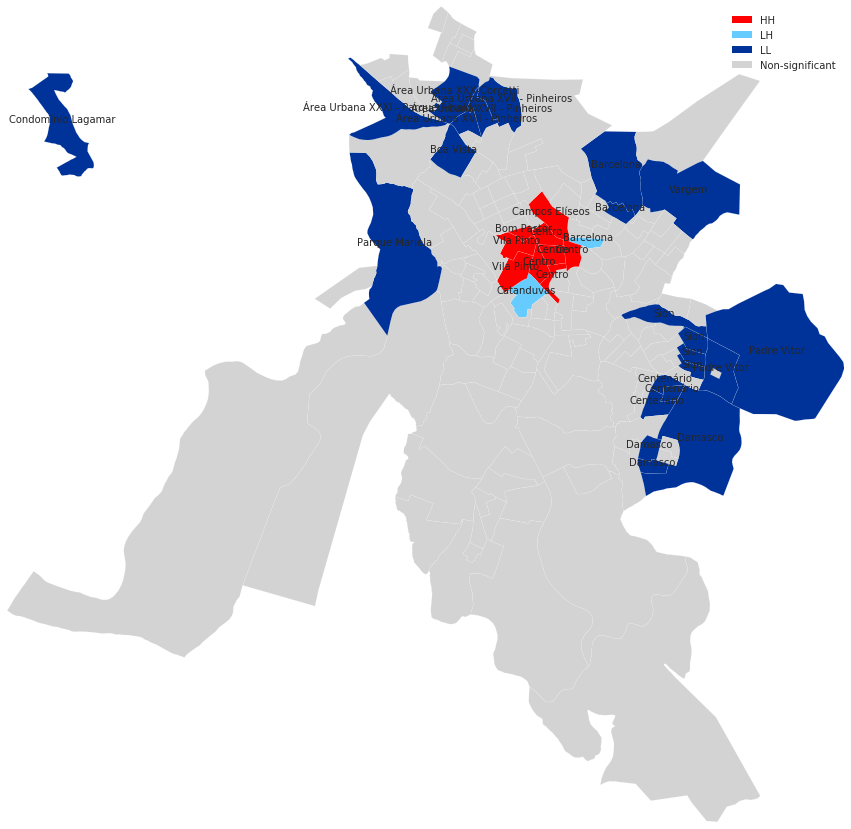

In [49]:
# plotar os nomes dos clusters e outliers espaciais 
fig = plt.figure(figsize=(15, 15))
shp = ps.open(shapefile)
base = maps.map_poly_shp(shp)
base = maps.base_lisa_cluster(base, lisa, p_thres=p_thres)
base.set_edgecolor('1')
base.set_linewidth(0.1)
ax = maps.setup_ax([base], [shp.bbox])

boxes, labels = maps.lisa_legend_components(lisa, p_thres=p_thres)
plt.legend(boxes, labels, fancybox=True)

for i in setores_escolhidos.index:

    plt.text(setores_escolhidos.geometry.centroid[i].coords[0][0], setores_escolhidos.geometry.centroid[i].coords[0][1], 
             setores_escolhidos.NM_BAIRRO[i],
             fontsize=10, horizontalalignment='center', verticalalignment='bottom')